LOAD DATASET

In [3]:
import pandas as pd

df = pd.read_csv("../../../data/processed/balanced_df.csv")

print(df.shape)
print(df.head())
print(df['label'].value_counts())

(170230, 2)
                                                text label
0                                                NaN  FAKE
1  kerry says us remains committed to nato allian...  REAL
2                                                NaN  FAKE
3  trump market has not fully digested tax cut ch...  REAL
4                                                NaN  FAKE
label
FAKE    85115
REAL    85115
Name: count, dtype: int64


In [4]:
df.isnull().sum()

text     133552
label         0
dtype: int64

Test Train Split

In [5]:
from sklearn.model_selection import train_test_split

X = df['text'].astype(str)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training Size: {X_train.shape[0]}")
print(f"Test Size: {X_test.shape[0]}")

Training Size: 136184
Test Size: 34046


Vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=25000,
    max_df=0.8,
    min_df=5,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF matrix shape (train)",X_train_tfidf.shape)
print("TF-IDF matrix shape (test)",X_test_tfidf.shape)


TF-IDF matrix shape (train) (136184, 25000)
TF-IDF matrix shape (test) (34046, 25000)


LOGISTIC REGRESSION MODEL

In [7]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000,class_weight='balanced')
clf.fit(X_train_tfidf,y_train)

y_pred = clf.predict(X_test_tfidf)

EVALUATE PERFOMANCE

              precision    recall  f1-score   support

        FAKE     0.9903    0.2754    0.4309     17023
        REAL     0.5792    0.9973    0.7328     17023

    accuracy                         0.6363     34046
   macro avg     0.7847    0.6363    0.5819     34046
weighted avg     0.7847    0.6363    0.5819     34046



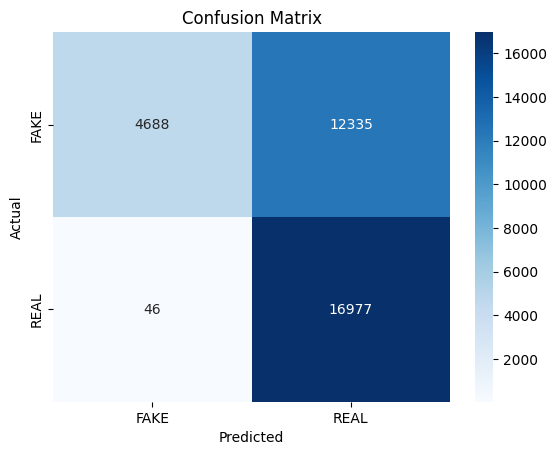

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


print(classification_report(y_test,y_pred, digits=4))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=clf.classes_,yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## ROC CURVE AND THINGS

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # "REAL" -> 1, "FAKE" -> 0
y_test_enc  = le.transform(y_test)


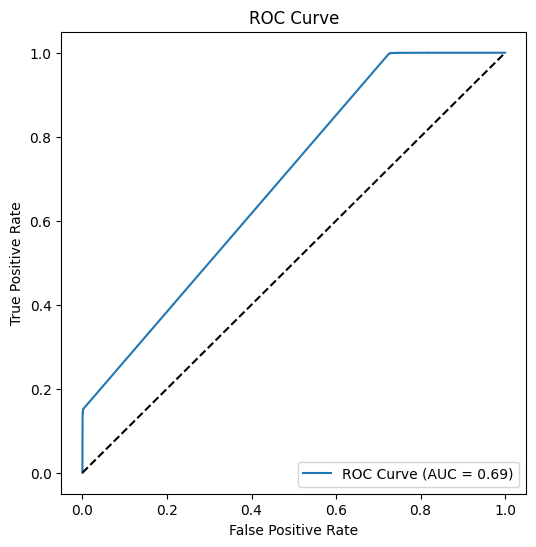

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Use decision_function (for SVM) or predict_proba (for LR, NB, etc.)
y_prob = clf.decision_function(X_test_tfidf)

fpr, tpr, _ = roc_curve(y_test_enc, y_prob)
roc_auc = roc_auc_score(y_test_enc, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


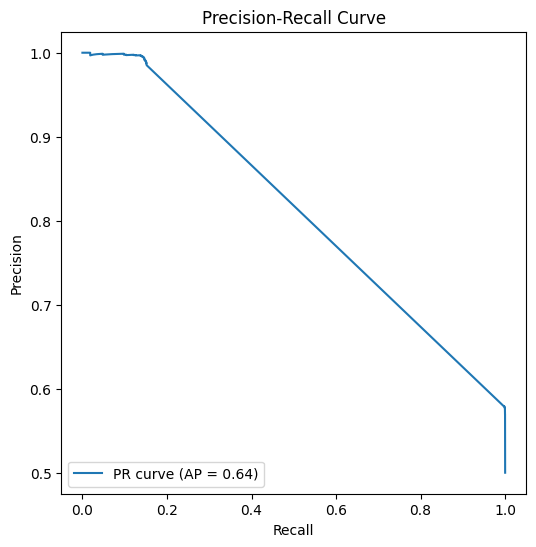

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test_enc, y_prob)
ap_score = average_precision_score(y_test_enc, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f"PR curve (AP = {ap_score:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


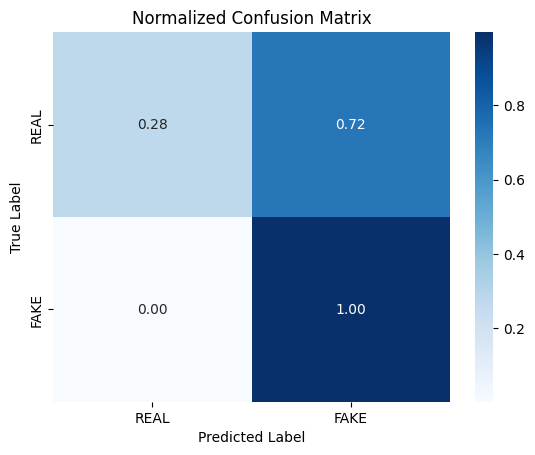

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, normalize="true")  # normalized
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=["REAL","FAKE"], yticklabels=["REAL","FAKE"])
plt.title("Normalized Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [14]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc = cross_val_score(clf, X_train_tfidf, y_train, cv=cv, scoring="accuracy")
f1 = cross_val_score(clf, X_train_tfidf, y_train, cv=cv, scoring="f1")
roc = cross_val_score(clf, X_train_tfidf, y_train, cv=cv, scoring="roc_auc")

print("Cross-validation results:")
print(f"Accuracy: {acc.mean():.3f} ± {acc.std():.3f}")
print(f"F1 Score: {f1.mean():.3f} ± {f1.std():.3f}")
print(f"ROC-AUC:  {roc.mean():.3f} ± {roc.std():.3f}")


c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_response.py", line 207, in _get_response_values
  

Cross-validation results:
Accuracy: 0.635 ± 0.003
F1 Score: nan ± nan
ROC-AUC:  0.690 ± 0.003
